In [58]:
# add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

from utils import dataset_INCan
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import sklearn
# normalize the features
from sklearn.preprocessing import StandardScaler
# classifiers
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
# use leave one out cross validation
from sklearn.model_selection import LeaveOneOut
# metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import roc_curve

In [82]:
# create predictor class
class predictor_machine():
    def __init__(self):
        
        self.clf = None
        self.scaler = StandardScaler()
        self.cv = LeaveOneOut()
        self.original_features = None
        self.features = None
        self.num_samples = 0
        self.receptor = None
        self.labels = None
        # lists
        self.probabilities = []
        self.true_labels = []
        self.best_estimators = []
        # budget
        self.budget = pd.read_csv(repo_path / 'data/budget/budget_std.csv', index_col=0).mean(axis=0)
        self.synthetic_units = 1
        self.X_test_augmented = None

    def set_classifier(self, pred:sklearn.base.BaseEstimator, parameters:dict, verbose:int=0):
        # grid search, the best model is selected based on the roc_auc score
        self.clf = GridSearchCV(pred, parameters, cv=5, scoring='roc_auc', verbose=verbose, n_jobs=6)

    def prepare_features(self, features:pd.DataFrame, show_info=True, scale_together=False):
        """with the defined scaler, scale feature and return as a dataframe

        Args:
            features (pd.DataFrame): input features, in order of prediction. Only numerical values.

        Returns:
            pd.DataFrame: scaled features
        """
        # ensure index is in order
        # features = features.sort_index()
        self.original_features = features.copy()
        if scale_together:
            self.scaler.fit(features)
            features = pd.DataFrame(self.scaler.transform(features))
            # show worning
            print('Features scaled together. This could represent DATA LEAKAGE.')
        self.num_samples = len(features)
        if show_info:
            print(f'Features prepared, {self.num_samples} samples, {features.shape[1]} features.')
        self.features = features

    def set_receptor(self, receptor:str, show_distribution:bool=False):
        """set the receptor to predict, it prepare the labels format

        Args:
            receptor (str): name of the receptor to predict
            show_distribution (bool, optional): show the positive distribution. Defaults to False.
        """
        self.receptor = receptor
        labels = dataset_INCan().labels_list(receptor=self.receptor)
        self.labels = pd.DataFrame(labels, columns=[self.receptor])
        if show_distribution:
            print(f'The positive cases of {self.receptor} represent {self.labels[self.receptor].mean().round(3)*100}%')  

    def train(self):
        for train_index, test_index in self.cv.split(self.features):
            # get the train and test data
            X_train, X_test = self.features.iloc[train_index], self.features.iloc[test_index]
            # scale the data
            X_train = self.scaler.fit_transform(X_train)
            X_test = self.scaler.transform(X_test)
            # get the train and test labels
            y_train, y_test = self.labels.iloc[train_index], self.labels.iloc[test_index]
            # fit the model
            self.clf.fit(X_train, y_train.values.ravel())
            # save best params of this iteration
            self.best_estimators.append(self.clf.best_estimator_)
            # predict the probability
            y_prob = self.clf.predict_proba(X_test)
            # append the prediction
            self.probabilities.append(y_prob)
            self.true_labels.append(y_test.values[0])
        # convert to arrays
        self.true_labels = np.asarray(self.true_labels)[:,0]
        self.probabilities = np.asanyarray(self.probabilities).reshape(-1,2)[:,0]

        print(f'Training finished!')

    def compute_metrics(self, plot_metrics:bool=True):
        
        roc_auc = roc_auc_score(self.true_labels, self.probabilities)
        fpr, tpr, thresholds = roc_curve(self.true_labels, self.probabilities)
        # get ideal threshold
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        # get optimal predictions
        optimal_predictions = np.where(self.probabilities > optimal_threshold, 1, 0)
        accuracy = accuracy_score(self.true_labels, optimal_predictions)
        precision = precision_score(self.true_labels, optimal_predictions)
        recall = recall_score(self.true_labels, optimal_predictions)
        f1 = f1_score(self.true_labels, optimal_predictions)
        if not plot_metrics:
            print(f'\nAUC:{roc_auc}\nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1: {f1}\n')
        if plot_metrics:
            # plot confusion matrix on the left
            fig, ax = plt.subplots(1,3, figsize=(15,5))
            cm = confusion_matrix(self.true_labels, optimal_predictions)
            ConfusionMatrixDisplay(cm).plot(ax=ax[0])
            ax[0].set_title('Confusion Matrix')
            # plot the ROC curve on the right
            ax[1].plot(fpr, tpr, label=f'ROC curve (area = {roc_auc})')
            ax[1].plot([0,1],[0,1], 'k--')
            ax[1].set_xlabel('False Positive Rate')
            ax[1].set_ylabel('True Positive Rate')
            ax[1].set_title('ROC Curve')
            ax[1].scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='black', label=f'Best Threshold: {optimal_threshold.round(3)}')
            ax[1].legend()
            # plot the metrics on the right, using thin bars
            ax[2].barh(['Accuracy', 'Precision', 'Recall', 'F1'], [accuracy, precision, recall, f1], height=0.5)
            # set the limits
            ax[2].set_xlim(0,1)
            ax[2].set_xticks(np.arange(0,1.1,0.1))
            # write the values on the bars
            for i, v in enumerate([accuracy, precision, recall, f1]):
                ax[2].text(v+0.01, i-0.1, f'{v.round(2)}')
                
            ax[2].set_title('Metrics')
            fig.tight_layout()
            plt.show()
            
    def dumb_inference(self):
        """infere with a feature vector of zeros"""
        # restart the lists
        self.probabilities = []
        self.true_labels = []
        # create a dumb feature vector
        dumb_features = pd.DataFrame(np.zeros((self.features.shape[0], self.features.shape[1])))
        # predict
        for _, test_index in self.cv.split(self.features):
            # get the train and test data
            X_test = dumb_features.iloc[test_index]
            y_test = self.labels.iloc[test_index]
            # predict the probability
            y_prob = self.best_estimators[test_index[0]].predict_proba(X_test)
            # append the prediction
            self.probabilities.append(y_prob)
            self.true_labels.append(y_test.values[0])
        # convert to arrays
        self.true_labels = np.asarray(self.true_labels)[:,0]
        self.probabilities = np.asanyarray(self.probabilities).reshape(-1,2)[:,0]
        print('Dumb prediction, using zero-valued feature vectors, NO training done.')

    def ordered_inference(self):
        # restart the lists
        self.probabilities = []
        self.true_labels = []
        # predict
        for _, test_index in self.cv.split(self.features):
            # get the train and test data
            X_test = self.features.iloc[test_index]
            y_test = self.labels.iloc[test_index]
            # predict the probability
            y_prob = self.best_estimators[test_index[0]].predict_proba(X_test)
            # append the prediction
            self.probabilities.append(y_prob)
            self.true_labels.append(y_test.values[0])
        # convert to arrays
        self.true_labels = np.asarray(self.true_labels)[:,0]
        self.probabilities = np.asanyarray(self.probabilities).reshape(-1,2)[:,0]
        print('Recomputed prediction, NO training done.')

    def budget_inference(self):
        # restart the lists
        self.probabilities = []
        self.true_labels = []

        # predict
        for _, test_index in self.cv.split(self.features):
                # repeat the test sample to match the number of synthetic samples
                y_test = self.labels.iloc[test_index]
                y_test_augmented = np.repeat(y_test, self.synthetic_units, axis=0)

                # generate the synthetic samples
                X_test_base = self.original_features.iloc[test_index]
                self.X_test_augmented = self.augment_test(X_test_base)

                # predict the probability
                y_prob = self.best_estimators[test_index[0]].predict_proba(self.X_test_augmented)

                # append the prediction
                self.probabilities.append(y_prob)
                self.true_labels.append(y_test_augmented)
        # convert to arrays
        self.true_labels = np.asarray(self.true_labels).reshape(-1,1)[:,0]
        self.probabilities = np.asanyarray(self.probabilities).reshape(-1,2)[:,0]
        print('Computed prediction using budge, NO training done.')

    def augment_test(self, X_test_base:pd.DataFrame):
        """given a base test set, augment it with random samples from a gaussian distribution with mean zero and std given by the budget

        Args:
            X_test_base (pd.DataFrame): base of the augmentation

        Returns:
            pd.DataFrame: augmented test set
        """
        X_test_base = pd.concat([X_test_base]*self.synthetic_units, ignore_index=True)
        # generate 1000 random samples from a gaussian distribution, mean zero and std given by the budget
        random_samples = np.random.normal(0, self.budget, size=(self.synthetic_units,1024))
        random_samples = pd.DataFrame(random_samples, columns=X_test_base.columns)
        # sum the random samples to the base features
        X_test_augmented = X_test_base + random_samples

        # scale according to scaler
        X_test_augmented = pd.DataFrame(self.scaler.transform(X_test_augmented))

        # send all the features to 0
        X_test_augmented = np.where(X_test_augmented < 0, 0, X_test_augmented)
        X_test_augmented = np.where(X_test_augmented > 0, 0, X_test_augmented)
        X_test_augmented = pd.DataFrame(X_test_augmented)

        return X_test_augmented

In [83]:
# Input data
features = pd.read_csv(repo_path / 'data/deep/features/features_1024/L_2_features.csv', index_col=0)
# remove zero columns
features = features.loc[:, (features != 0).any(axis=0)]
# compute the correlation matrix
corr = features.corr().abs()
# get the upper triangle of the correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
# find features with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
# drop features
features.drop(to_drop, axis=1, inplace=True)
print(features.shape)

(33, 935)


The positive cases of RP represent 63.6%
Features prepared, 33 samples, 935 features.
Training finished!


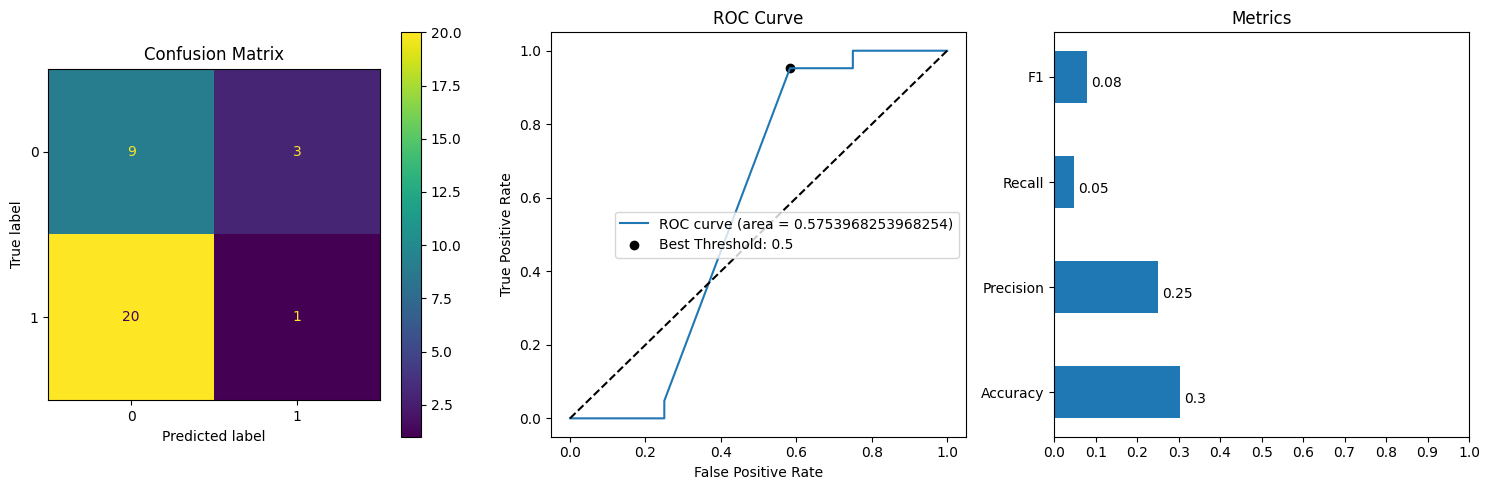

Dumb prediction, using zero-valued feature vectors, NO training done.


/home/ricardo/miniconda3/envs/cedm-deep/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


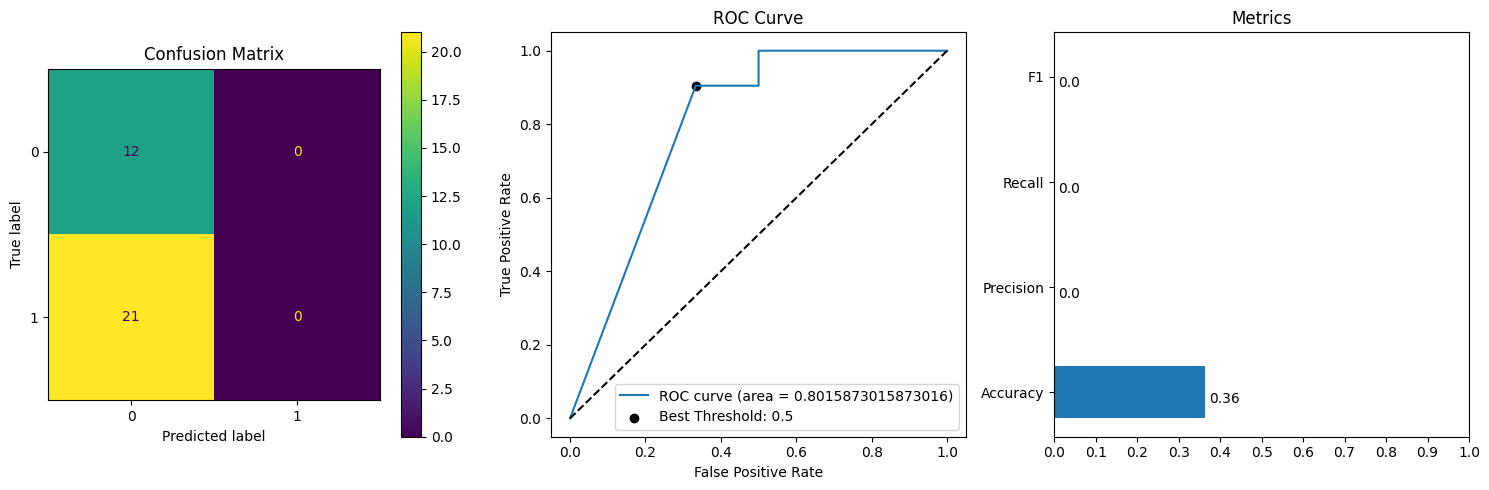

In [85]:
# Input data
receptor = 'RP'

# prepare for the machine
predictor = predictor_machine()
predictor.set_receptor(receptor, show_distribution=True)

# pred = LogisticRegression(class_weight='balanced')
# parameters = {'penalty':['l2'], 'C':[0.01, 0.1, 1, 10], 'solver':['liblinear', 'lbfgs']}
# pred = SVC(probability=True, class_weight='balanced')
# parameters = {'kernel':('linear', 'rbf'), 'C':[0.01, 0.1, 1, 10], 'gamma':[0.01, 0.1, 1]}
# pred = RandomForestClassifier(class_weight='balanced')
# parameters = {'n_estimators':[10, 100, 1000], 'max_depth':[None, 10, 100], 'max_features':[None, 10, 100]}
pred = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced')
parameters = {'C':[0.01, 0.1, 1, 10]}
predictor.set_classifier(pred, parameters, verbose=0)

predictor.prepare_features(features)
predictor.train()
predictor.compute_metrics(plot_metrics=True)
predictor.dumb_inference()
predictor.compute_metrics(plot_metrics=True)